In [25]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from nilearn import plotting
import os
import nibabel as nib
from scipy import stats
from scipy.spatial.distance import squareform
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection

#### This notebook visualizes representational dissimilarity matrices (RDMs) computed from the metadata and correlates them with the neural RDMs (from version A). Note how the different metadata correlate better/worse in different brain regions. For example, the scene metadata RDM correlates strongly in what appears to be scene-selective regions, while the object metadata RDM results in a noticeably different correlation profile. This analysis corresponds to Figure 7c in the manuscript.

In [26]:
def visualize_glass_brain(stat, metadata_label, roi_path):
    brain_mask = nib.load(os.path.join(roi_path,"example.nii"))
    stat_nii = nib.Nifti1Image(stat, brain_mask.affine)
    plotting.plot_glass_brain(stat_nii,
                            plot_abs=False,
                            cmap='hot_r',
                            display_mode='lyrz',
                            title=f"{metadata_label} RDM correlation",
                            colorbar=True) 
    plt.show()
    plt.clf()
    
def get_lowertriangular(rdm):
    num_conditions = rdm.shape[0]
    return rdm[np.triu_indices(num_conditions,1)]

def visualize_RDMs(rdms, metadata_labels):
    assert(len(rdms) == len(metadata_labels))
    num_rdms = len(rdms)
    fig, axes = plt.subplots(1, num_rdms, figsize=(15, 5))

    for i, (rdm, metadata_label) in enumerate(zip(rdms, metadata_labels)):
        rdm_rank = stats.rankdata(get_lowertriangular(rdm))
        rdm_rank_norm = rdm_rank / rdm_rank.max()
        rdm_rank_square = squareform(rdm_rank_norm)
        
        ax = axes[i] if num_rdms > 1 else axes  # Handle single subplot case
        im = ax.imshow(rdm_rank_square, cmap='jet')
        ax.set_title(f"{metadata_label} rank normalized RDM")
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

In [27]:
#set up paths
dataset_root = "/data/vision/oliva/scratch/datasets/BOLDMomentsDataset" #"/your/path/to/BOLDMomentsDataset"

subjects = ['01','02','03','04','05','06','07','08','09','10']
rsa_root = os.path.join(dataset_root, "derivatives", "versionA", "analysis", "metadataRSA")
searchlight_path = os.path.join(dataset_root, "derivatives", "versionA", "MNI152", "prepared_data","prepared_searchlight_pkl")

roi_path = os.path.join(dataset_root, "derivatives", "versionA", "MNI152", "GLM", "ROIs")
metadata_labels = ["scenes","objects"] #we will just compare scenes and objects for now but we can also do the other metadata labels -["objects", "scenes", "actions", "ActionsObjectsScenes","text_descriptions"] 
task = "test"
dims=(78, 93, 71)


In [28]:
#load the upper noise ceiling for noise normalization
fname = os.path.join(searchlight_path, f"noiseceiling-upper_searchlight-BetasAvg_task-{task}_TRavg-56789_radius-4.pkl")
with open(os.path.join(searchlight_path,fname),'rb') as fh:
    upper,mask_master = pickle.load(fh)
n_voxels = len(mask_master)

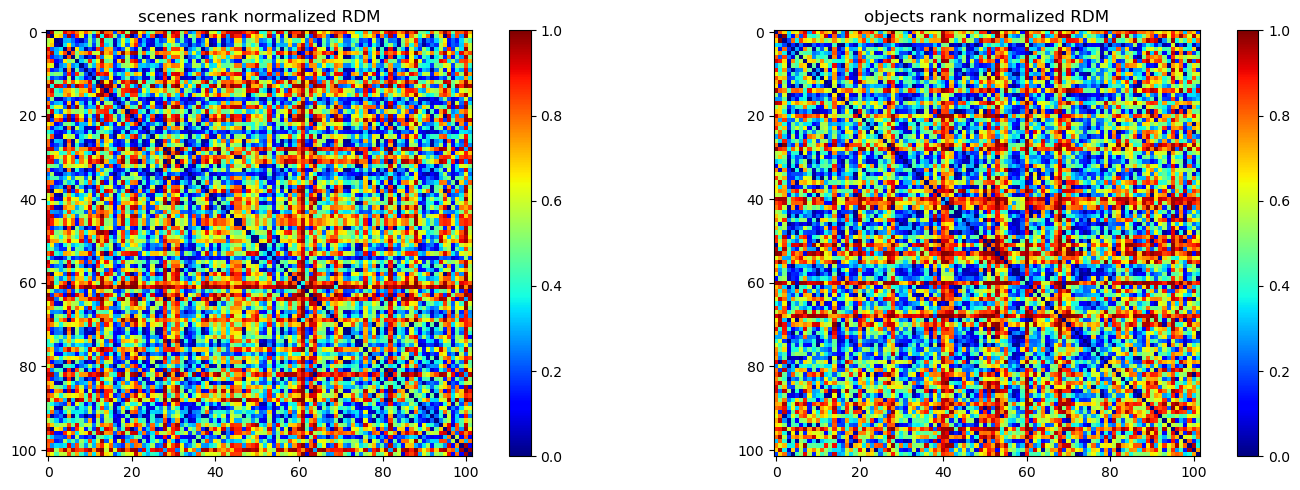

In [29]:
rdms = []
for metadata_label in metadata_labels:
    rdm = np.load(os.path.join(rsa_root, "rdms", f"MetadataRDM_humanAnnotated_label-{metadata_label}_task-{task}_metric-cosine.npy")) #loads the appropriate metadata RDM
    rdms.append(rdm)
    
visualize_RDMs(rdms, metadata_labels) #optionally visualize this RDM

01
02
03
04
05
06
07
08
09
10


100%|██████████| 515034/515034 [03:24<00:00, 2516.18it/s]


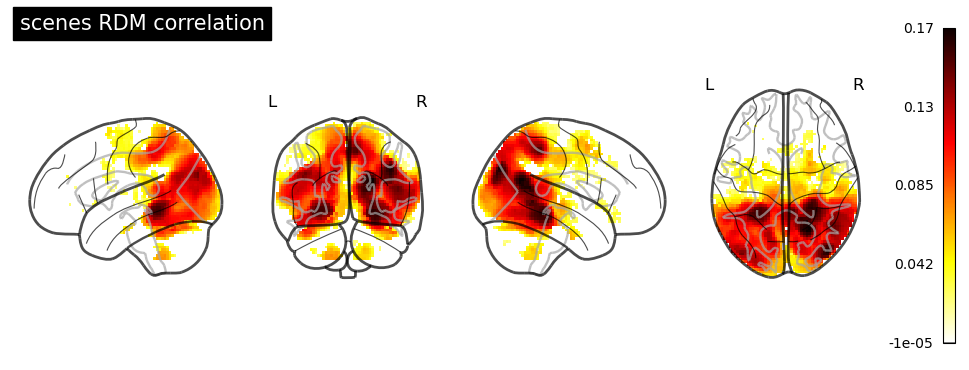

01
02
03
04
05
06
07
08
09
10


100%|██████████| 515034/515034 [03:22<00:00, 2543.03it/s]


<Figure size 640x480 with 0 Axes>

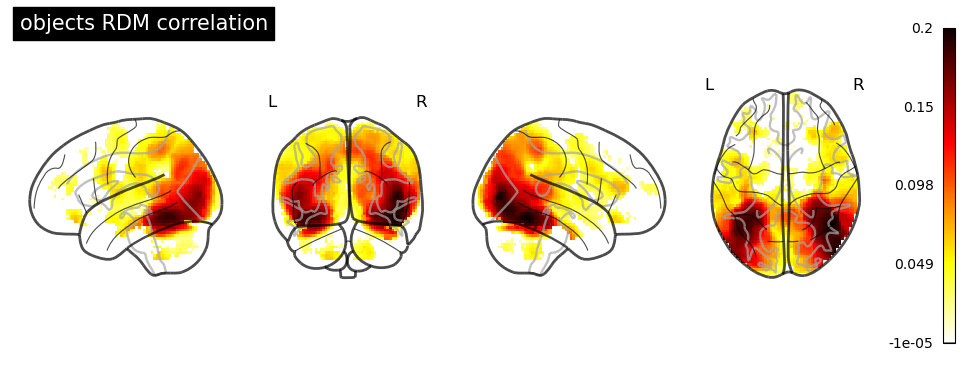

<Figure size 640x480 with 0 Axes>

In [30]:
for metadata_label in metadata_labels:
    corr_1D_all = np.zeros((len(subjects), n_voxels))
    for s, sub in enumerate(subjects): #load all subject's searchlight-metadata correlations and store them in a 4D array
        print(sub)
        #load the subject's searchlight-metadata correlations
        fname =  f"sub{sub}_RSA-BetasAvg_task-{task}_corr-spearman_metadata-{metadata_label}_stats-FDR-q-0.05-method-poscorr.pkl"
        with open(os.path.join(rsa_root, fname), 'rb') as fh:
            corr, _, _, nan_indices = pickle.load(fh) #(corr, pval, fdr_tuple, nan_indices)
        
        #mask correlations by nans and add to the all subject array
        corr_1D = np.ones((n_voxels,))
        corr_1D[nan_indices.astype(int)] = 0
        corr_1D[corr_1D == 1] = corr
        corr_1D_all[s,:] = corr_1D

        del corr, nan_indices, corr_1D
        
    #Plot the glass brain of average RSA correlations per voxel masked by FDR significance
    #do ttest
    pval = np.zeros((n_voxels,))
    for vox in tqdm(range(n_voxels)): #performs a ttest at each voxel over the 10 subjects. Gets a p-value for each voxel. The null hypothesis is that the searchlight-metadata correlation is zero
        pval[vox] = stats.ttest_1samp(corr_1D_all[:,vox], popmean=0, alternative='two-sided')[1]

    #do FDR correction
    rejected, pval_corrected = fdrcorrection(pval[~np.isnan(pval)], alpha=0.05,  method='poscorr', is_sorted=False) #to address multiple comparisons, FDR correct over all voxels that are not nans (inside the brain)

    #plot average correlation masked by FDR significance
    #create significance mask from FDR
    pval_mask = np.ones((n_voxels,))
    pval_mask[np.isnan(pval)] = 0
    pval_mask[pval_mask==1] = rejected #1D array of 1's and 0's where 1 means that voxel survived FDR correction
    pval_mask_3D = pval_mask.reshape(dims) #reshape to a 3D matrix
    
    #manipulate the upper noise ceiling a bit to be compatible with our correlation matrix
    upper_1D_all = np.zeros((len(subjects),n_voxels))
    upper_1D_all[:,mask_master == 1] = upper #fill in the upper noise ceiling values for each subject in a subject x voxels matrix
    upper_1D_all[:,mask_master == 0] = np.nan #change zeros to nans to make it easier to divide

    corr_1D_norm = corr_1D_all / upper_1D_all #normalizes each subject's searchlight-metadata correlations by their upper noise ceiling
    corr_1D_norm[:,mask_master == 0] = 0 #go back to changing nans to zeros
    corr_3D_norm = corr_1D_norm.reshape((len(subjects),dims[0],dims[1],dims[2])) #reshape these normalized values into 3D

    corr_3D_norm_avg = np.nanmean(corr_3D_norm, axis=0) #simply average the normalized values over the 10 subjects at each voxel (mirrors the unnomralized computation above)
    corr_3D_norm_avg_masked = corr_3D_norm_avg * pval_mask_3D #now mask the subject-averaged result by those voxels that survived FDR correction

    #mask results by significance and visualize
    corr_3D_norm_avg_masked[corr_3D_norm_avg_masked<0] = 0 #threshold at 0
    visualize_glass_brain(corr_3D_norm_avg_masked, metadata_label, roi_path)